In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.utils.data import Subset

sns.set_style('whitegrid')

In [3]:
def display_result_season(y_true, y_pred, index):
    """
    Fonction fournie par l'utilisateur pour la visualisation saisonnière.
    y_true : Pandas Series avec DatetimeIndex
    y_pred : Array numpy ou Pandas Series (valeurs prédites)
    """
    dmap = {
        12: 'DJF', 1: 'DJF', 2: 'DJF',
        3: 'MAM', 4: 'MAM', 5: 'MAM',
        6: 'JJA', 7: 'JJA', 8: 'JJA',
        9: 'SON', 10: 'SON', 11: 'SON'
    }
    cmap = {"DJF": "tab:blue", "MAM": "tab:green",
            "JJA": "tab:red", "SON": "tab:orange"}
    
    # Vérification et mappage des saisons
    seasons = index.month.map(dmap)
    colors = seasons.map(cmap)

    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1 : Séries Temporelles
    ax1.set_title("Capacity factor predictions")
    ax1.plot(index, y_true, color="tab:blue", label="Actual")
    ax1.plot(index, y_pred, color="tab:red", label="Predicted")
    ax1.set_xlim(index[0], index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2 : Scatter Plot (Actual vs Predicted)
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, c=colors, s=10)

    # Diagonale idéale (y=x)
    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_xlim(lb, ub)
    ax2.set_ylim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    # Légende des saisons
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=s, 
                   markerfacecolor=cmap[s], markersize=6)
        for s in ["DJF", "MAM", "JJA", "SON"]
    ]
    ax2.legend(handles=handles, title="Season")

    plt.show()

In [4]:
cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

cf = cf[["FR"]]
ta = ta.loc[:, ta.columns.str.startswith("FR")]
tp = tp.loc[:, tp.columns.str.startswith("FR")]

data = pd.concat([ta.mean(axis=1).rename("TA"),
                  tp.mean(axis=1).rename("TP"),
                  cf["FR"].rename("CF")], axis=1)

In [19]:
# ==========================================
# 1. Configuration Globale (Hyperparamètres)
# ==========================================
class Config:
    # Fenêtres physiques (Feature Engineering)
    WINDOW_TP = 7    # Jours pour l'accumulation de pluie
    WINDOW_TA = 30   # Jours pour l'inertie thermique
    
    # Fenêtres du Modèle (Architecture LSTM)
    SEQ_LENGTH = 90  # Look-back window (Profondeur BTT)
    PRED_HORIZON = 1 # Prédiction à t+1
    
    # Architecture
    HIDDEN_SIZE = 258
    NUM_LAYERS = 4
    DROPOUT = 0.2
    BATCH_SIZE = 30
    
    # Entraînement
    LR = 0.001
    EPOCHS = 100
    DROPOUT = 0.2

CONFIG = Config()

In [8]:
#Choisir une machine
device = torch.device("cuda:0")

In [9]:
# ==========================================
# 2. Préparation des données
# ==========================================
X1 = data.drop(columns="CF")
yn = data["CF"]

#ajout d'une feunêtre
X_days_TP = X1["TP"].rolling(window=CONFIG.WINDOW_TP, min_periods=1).sum()
X_days_TA = X1["TA"].rolling(window=CONFIG.WINDOW_TA, min_periods=1).mean()
X_days_TP = X_days_TP.reset_index(drop=True)
X_days_TA = X_days_TA.reset_index(drop=True)

#Création du tableau
Xn = pd.concat([X_days_TP, X_days_TA], axis = 1)

#Création des séries temporelles
Xt = []
yt = []
for i in range(len(Xn)-CONFIG.SEQ_LENGTH):
    Xt.append(Xn.iloc[i:i+CONFIG.SEQ_LENGTH])
    yt.append(yn.iloc[i+CONFIG.SEQ_LENGTH])
Xt =  np.array(Xt)
yt = np.array(yt)

#Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

ds = TimeSeriesDataset(Xt, yt)
#Mise en GPU (la puissance)
ds.X = ds.X.to(device)
ds.y = ds.y.to(device)

#création des sous dataset

total_len = len(ds)
test_len = 365
split_idx = total_len - test_len

train_indices = range(0, split_idx)
test_indices = range(split_idx, total_len)

train_ds = Subset(ds, train_indices)
test_ds = Subset(ds, test_indices)

# Gestionnaire de batchs
train_loader = DataLoader(train_ds, batch_size=CONFIG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

In [10]:
# ==========================================
# 3. Le modèle de deep learning
# ==========================================
torch.set_num_threads(20)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couche LSTM
        # input_shape attendu : (batch_size, sequence_length, input_size)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout
        )
        
        # Couche entièrement connectée pour la régression finale
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialisation des états cachés (h_0, c_0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Propagation avant (Forward pass)
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # On récupère seulement la sortie du dernier pas de temps de la séquence
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = out[:, -1, :]
        
        # Prédiction finale
        out = self.fc(out)
        return out

In [20]:
# ==========================================
# 4. Entrainement
# ==========================================
#torch.manual_seed(42)
torch.set_num_threads(20)

input_dim = len(X1.columns)
model = LSTM(
    input_size=input_dim, 
    hidden_size=CONFIG.HIDDEN_SIZE, 
    num_layers=CONFIG.NUM_LAYERS, 
    output_size=1,
    dropout=CONFIG.DROPOUT
).to(device)



criterion = nn.MSELoss().to(device)
optimizer = Adam(params=model.parameters(), lr=CONFIG.LR)

# Paramètres pour la normalisation
Xstd, *_ = train_ds.dataset[train_ds.indices]
mu, sigma = Xstd.mean(dim=0), Xstd.std(dim=0)

train_history = []

print("Début de l'entraînement...")
for epoch in range(CONFIG.EPOCHS):
    model.train()
    batch_loss = []
    
    for X_batch, y_batch in train_loader:
        X_batch = (X_batch - mu) / sigma
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch) # squeeze pour ajuster les dimensions
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
    
    train_epoch_loss = np.mean(batch_loss)
    
    # Évaluation (Validation)
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val = (X_val - mu) / sigma
            outputs = model(X_val)
            v_loss = criterion(outputs.squeeze(), y_val)
            val_loss.append(v_loss.item())
            
    test_epoch_loss = np.mean(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{CONFIG.EPOCHS}], Train Loss: {train_epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}")
    
print("Entraînement terminé.")

Début de l'entraînement...
Epoch [10/100], Train Loss: 0.0142, Test Loss: 0.0076
Epoch [20/100], Train Loss: 0.0085, Test Loss: 0.0071
Epoch [30/100], Train Loss: 0.0063, Test Loss: 0.0029
Epoch [40/100], Train Loss: 0.0188, Test Loss: 0.0120
Epoch [50/100], Train Loss: 0.0174, Test Loss: 0.0116
Epoch [60/100], Train Loss: 0.0108, Test Loss: 0.0072
Epoch [70/100], Train Loss: 0.0058, Test Loss: 0.0040
Epoch [80/100], Train Loss: 0.0042, Test Loss: 0.0028
Epoch [90/100], Train Loss: 0.0033, Test Loss: 0.0032
Epoch [100/100], Train Loss: 0.0030, Test Loss: 0.0038
Entraînement terminé.


R2: 0.621634
MSE: 0.004082


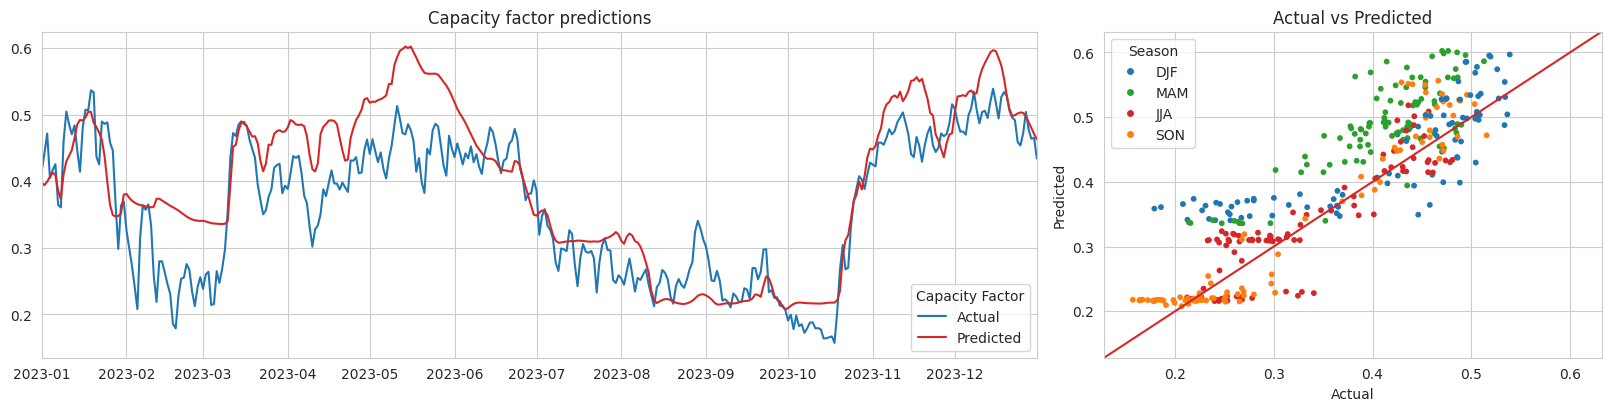

In [21]:
model.eval()
with torch.no_grad():
    predict = []
    true = []
    for X, y in test_loader :
        X = (X-mu)/sigma
        y_hat = model(X)
        predict.extend(y_hat.cpu())
        true.extend(y.cpu())
    index = X1.index[len(X1)-365:]
    r2 = r2_score(true, predict)
    mse = mean_squared_error(true, predict)
    print(f"R2: {r2:.06f}")
    print(f"MSE: {mse:.06f}")
    display_result_season(true, predict, index)